<a href="https://colab.research.google.com/github/GuiCoelhoDev/CoronaryDisease_Analysis/blob/main/Projeto1_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Google Drive Auth

In [2]:
#@title  Imports
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn import tree # for decision tree models

import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization
import graphviz # for plotting decision tree graphs

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [3]:
#@title  Google Drive Auth

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [10]:
#@title Load dataset

link = 'https://drive.google.com/file/d/1QFfy98RZcXYdx2U8SePO1TcYwZ236aPT/view?usp=sharing'

fluff, parsed = link.split('/d/')
id, fluff = parsed.split('/')

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('SA_heart.csv')  
dataset = pd.read_csv('SA_heart.csv')
dataset=dataset[pd.isnull(dataset['chd'])==False]
dataset=dataset.fillna(dataset.mean())
dataset
# Dataset is now stored in a Pandas Dataframe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if sys.path[0] == '':


,id,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1
...,...,...,...,...,...,...,...,...,...,...,...
457,459,214,0.40,5.98,31.72,Absent,64,28.45,0.00,58,0
458,460,182,4.20,4.41,32.10,Absent,52,28.61,18.72,52,1
459,461,108,3.00,1.59,15.23,Absent,40,20.09,26.64,55,0
460,462,118,5.40,11.61,30.79,Absent,64,27.35,23.97,40,0


# Questão 1

### Summarize Data (Análise estatística dos dados)


Utilizando o método shape, foi possível perceber que temos 462 amostras com 11 colunas. Sendo 9 colunas sendo variáveis produtoras, uma para o identificador e outra para a classificação da amostra.

Posteriormente, foi utilizado o método sample. Foi escolhido ele em vez do head() ou tail() para poder pegar amostras aleatoriamente no dataset. Ao ver 20 amostras aleatórias, acredita-se que pessoas mais velhas tem mais chance de ter chd do que mais novos. Porém, não da pra ter certeza utilizando apenas esse método. É apenas uma hipótese

Observando os resultados do describe(), verifiquei que a maior parte das amostras são rotuladas como SEM chd pois a média desse valor está em 0.346320.
- Total: 462
- 65% (302)- 0 (hasnt CHD)
- 35% (160) - 1 (has CHD)

sbp -> systolic blood pressure

Perguntas a serem respondidas:

1.   Dado todos os testados positivos, qual a proporção de idade, alcohol, tobacco, etc deles?




In [11]:
#@title Análises gerais
print("\nShape")
print(dataset.shape)
print("\nSamples")
print(dataset.sample(20))
print("\nDescribe")
print(dataset[['obesity','tobacco', 'alcohol','chd']].describe())
print("\Columns")
print(dataset.columns)




Shape
(462, 11)

Samples
      id  sbp  tobacco   ldl  adiposity  ... typea  obesity  alcohol  age  chd
180  181  166     0.00  4.31      34.27  ...    45    30.14    13.27   56    0
330  332  154     0.31  2.33      16.48  ...    33    24.00    11.83   17    0
402  404  178     5.50  3.79      23.92  ...    45    21.26     6.17   62    1
442  444  166     6.00  8.80      37.89  ...    39    28.70    43.20   52    0
97    98  136     0.00  5.00      27.58  ...    49    27.59     1.47   39    0
201  202  136     3.15  4.37      20.22  ...    59    25.12    47.16   31    1
110  111  114     0.00  8.01      21.64  ...    66    25.51     2.49   16    0
96    97  138     2.16  4.90      24.83  ...    39    26.06    28.29   29    0
298  300  132    12.00  4.51      21.93  ...    61    26.07    64.80   46    1
52    53  152     0.90  9.12      30.23  ...    56    28.64     0.37   42    1
422  424  150    13.80  5.10      29.45  ...    52    27.92    77.76   55    1
68    69  118     4.46  7.

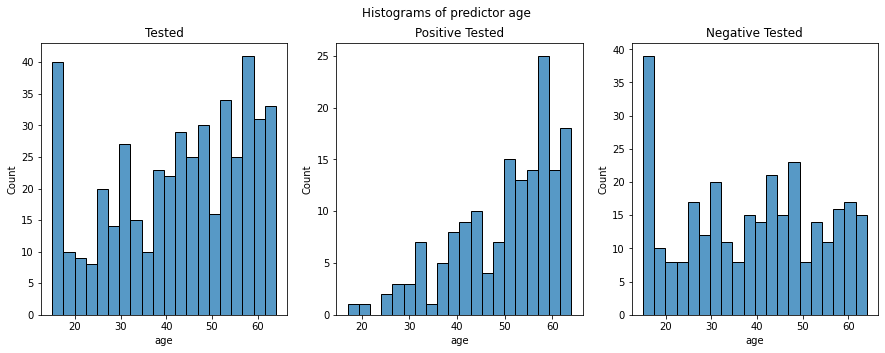

In [6]:
tested_positive = dataset.query('chd == 1')
tested_negative = dataset.query('chd == 0')

preditor_selecionado = 'age' #@param ['sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea', 'obesity', 'alcohol', 'age']

fig, axes = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Histograms of predictor {}'.format(preditor_selecionado))
sns.histplot(ax = axes[0], data=dataset, x=preditor_selecionado, bins=20)
axes[0].set_title("Tested")

sns.histplot(ax = axes[1],data=tested_positive, x=preditor_selecionado, bins=20)
axes[1].set_title("Positive Tested")

sns.histplot(ax = axes[2],data=tested_negative, x=preditor_selecionado, bins=20)
axes[2].set_title("Negative Tested")
plt.show()


Baseado nos histogramas acima pode-se concluir:


1.   Quanto maior a idade, maior a chance de ser testado positivo
2.   alcohol, sbp, e ldl não parecem ser preditores muito úteis para classificação
3.   A variável famhist é mais presente quando o paciente é testado positivamente. Enquanto a variável é mais ausente quando o paciente é testado negativamente.
4.  Incrivelmente, o fator obesidade e alcohol não é um preditor tão impactante quanto a idade, por exemplo.
5.  Inicialmente, achava que quanto maior o alcohol, obesity, tobacco, maior a chance de ser positivo. Porém, ao analisar os histogramas, percebe-se que a lógica é inversa. No caso do tobacco por exemplo, a maior parte se encontra perto do 0. E poucos se encontram perto de 40. Portanto, acredito que quanto menor o valor dessa variável, mais tabaco ela ingeriu. Pois não faz sentido pessoas que usarem mais tabaco terem menos chance de pegar do que quem não usou. Essa lógica se repete para alcohol, 



# Questão 2

## Referências do código utilizado:
https://towardsdatascience.com/cart-classification-and-regression-trees-for-clean-but-powerful-models-cc89e60b7a85
https://machinelearningmastery.com/machine-learning-in-python-step-by-step/
## Observações


1.   Para depth = 3, 'entropy', 'random', acuracia de 0.66666 sem utilizar validação cruzada
2.   Para depth = 4, 'entropy', 'random', acuracia de 0.71 sem utilizar validação cruzada
3. Não era para a validação cruzada ter um resultado melhor do que em?
4. 10 splits foi o que deu melhor resultado de acurácia (68,3%)
5. Com 10% dos dados para teste, o EvaluationTest caiu para 0.59. Antes era 0.66






In [13]:
#@title Functions

def fitting(X, y, criterion, splitter, mdepth, clweight):

    # Create training and testing samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


    # Fit the model
    model = tree.DecisionTreeClassifier(criterion=criterion, 
                                        splitter=splitter, 
                                        max_depth=mdepth,
                                        class_weight=clweight,
                                  
                                        random_state=0, 
                                  )
    
    # Cross validation test
    kfold = StratifiedKFold(n_splits=10, random_state=0, shuffle
    =True)

    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    print('Results of training CART')
    print('%s: %f (%f)' % ('CART', cv_results.mean(), cv_results.std()))

                                  
    clf = model.fit(X_train, y_train)

    # Predict class labels on training data
    pred_labels_tr = model.predict(X_train)
    # Predict class labels on a test data
    pred_labels_te = model.predict(X_test)

    # Tree summary and model evaluation metrics
    print('*************** Tree Summary ***************')
    print('Classes: ', clf.classes_)
    print('Tree Depth: ', clf.tree_.max_depth)
    print('No. of leaves: ', clf.tree_.n_leaves)
    print('No. of features: ', clf.n_features_in_)
    print('--------------------------------------------------------')
    print("")
    

    print('*************** Evaluation on Training Data ***************')
    score_tr = model.score(X_train, y_train)
    print('Accuracy Score: ', score_tr)
    # Look at classification report to evaluate the model
    print(classification_report(y_train, pred_labels_tr))
    print('--------------------------------------------------------')


    print('*************** Evaluation on Test Data ***************')
    score_te = model.score(X_test, y_test)
    print('Accuracy Score: ', score_te)
    # Look at classification report to evaluate the model
    print(classification_report(y_test, pred_labels_te))
    print('--------------------------------------------------------')
    print("")
    
  
    
    # Plotting Tree
    dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X.columns, 
                                class_names=[str(list(clf.classes_)[0]), str(list(clf.classes_)[1])],
                                filled=True, 
                                rounded=True, 
                                #rotate=True,
                               ) 
    graph = graphviz.Source(dot_data)
    
    # Return relevant data for chart plotting
    return X_train, X_test, y_train, y_test, clf, graph
                                 


Results of training CART
CART: 0.683033 (0.046204)
*************** Tree Summary ***************
Classes:  [0 1]
Tree Depth:  3
No. of leaves:  8
No. of features:  7
--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.6964769647696477
              precision    recall  f1-score   support

           0       0.69      0.96      0.80       241
           1       0.72      0.20      0.32       128

    accuracy                           0.70       369
   macro avg       0.71      0.58      0.56       369
weighted avg       0.70      0.70      0.64       369

--------------------------------------------------------
*************** Evaluation on Test Data ***************
Accuracy Score:  0.6666666666666666
              precision    recall  f1-score   support

           0       0.67      0.98      0.79        61
           1       0.67      0.06      0.11        32

    accuracy                           0.

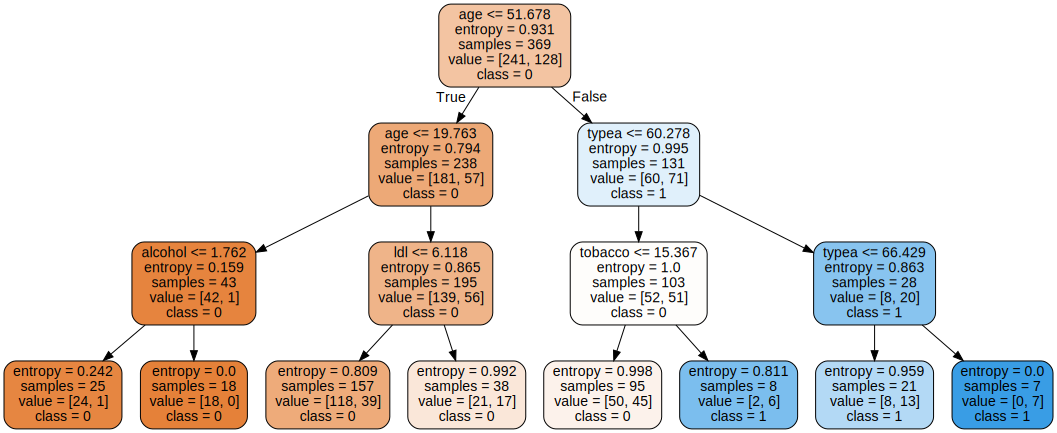

In [21]:
X=dataset[['tobacco','ldl','adiposity','typea','obesity','alcohol','age']]
y=dataset['chd'].values


X_train, X_test, y_train, y_test, clf,graph = fitting(X,y,'entropy','random',mdepth=3,clweight=None)
# Conforme aumenta a profundidade da árvore, vai se criando um Overfitting
# O treinamento fica com uma alta acurácia, porém o test não
graph



In [9]:
dataset[['sbp','tobacco','ldl','adiposity','typea','obesity','alcohol','age']]


,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age
0,160,12.00,5.73,23.11,49,25.30,97.20,52
1,144,0.01,4.41,28.61,55,28.87,2.06,63
2,118,0.08,3.48,32.28,52,29.14,3.81,46
3,170,7.50,6.41,38.03,51,31.99,24.26,58
4,134,13.60,3.50,27.78,60,25.99,57.34,49
...,...,...,...,...,...,...,...,...
457,214,0.40,5.98,31.72,64,28.45,0.00,58
458,182,4.20,4.41,32.10,52,28.61,18.72,52
459,108,3.00,1.59,15.23,40,20.09,26.64,55
460,118,5.40,11.61,30.79,64,27.35,23.97,40
